In [61]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas as pd

In [62]:
# === Ayarlar ===
IMG_SIZE = 128
IMG_CHANNELS = 3
LATENT_DIM = 128
BATCH_SIZE = 16
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FFHQ_PATH = "/kaggle/input/gen-ai/gen_AI/thumbnails128x128"  



In [63]:
# === Dataset ===
class FFHQDataset(Dataset):
    def __init__(self, folder):
        self.paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith((".png", ".jpg"))]
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)



In [64]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM, 512 * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (512, 4, 4)),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 64x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, IMG_CHANNELS, 4, 2, 1),  # 128x128
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)



In [65]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 128 * 3, 1024),  # 🟢 Burayı değiştirdik
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1)
        )

    def forward(self, img):
        return self.model(img)


In [66]:
class AudioToFaceDataset(Dataset):
    def __init__(self, csv_path, audio_dir, image_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.image_dir = image_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            image_path = os.path.join(self.image_dir, row["photo"])
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)
            return image, 0
        except Exception as e:
            # Eğer dosya yoksa None döndür
            return None
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None, None
    return torch.utils.data.default_collate(batch)
dataset = AudioToFaceDataset(csv_path, audio_dir, image_dir)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
for images, _ in dataloader:
    if images is not None:
        print(f"✅ Görsel şekli: {images.shape}")
        break


✅ Görsel şekli: torch.Size([7, 3, 128, 128])


In [67]:
# === Gradient Penalty ===
def compute_gradient_penalty(D, real, fake):
    alpha = torch.rand(real.size(0), 1, 1, 1).to(DEVICE)
    interpolated = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolated = D(interpolated)
    ones = torch.ones_like(d_interpolated).to(DEVICE)
    gradients = torch.autograd.grad(
        outputs=d_interpolated, inputs=interpolated,
        grad_outputs=ones, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()



In [79]:
import os
import torch.nn as nn

def train_ffhq():
    generator = nn.DataParallel(Generator()).to(DEVICE)

    # 💾 Eğer önceden kaydedilmiş model varsa working dizininden yükle
    pretrained_path_input = "/kaggle/input/generator_ffhq_pretrained/pytorch/default/1/generator_ffhq_pretrained(1).pth"
    pretrained_path_output = "/kaggle/working/generator_ffhq_pretrained_son.pth"

    if os.path.exists(pretrained_path_output):
        generator.load_state_dict(torch.load(pretrained_path_output))
        print("📦 Working dizininden model yüklendi.")
    elif os.path.exists(pretrained_path_input):
        generator.load_state_dict(torch.load(pretrained_path_input))
        print("📦 Input dizininden önceden eğitilmiş model yüklendi.")
    else:
        print("🚨 Önceden eğitilmiş model bulunamadı, sıfırdan eğitilecek.")

    discriminator = Discriminator().to(DEVICE)
    
    dataset = FFHQDataset(FFHQ_PATH)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    opt_G = optim.Adam(generator.parameters(), lr=1e-5, betas=(0.0, 0.9))
    opt_D = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.0, 0.9))

    best_loss = float("inf")
    trigger_times = 0
    patience = 5

    os.makedirs("samples_ffhq", exist_ok=True)

    for epoch in range(EPOCHS):
        g_loss_total = 0.0
        d_loss_total = 0.0

        print(f"\n🔁 Epoch {epoch+1}/{EPOCHS} başladı...")

        for i, real_imgs in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
            real_imgs = real_imgs.to(DEVICE)
            z = torch.randn(real_imgs.size(0), LATENT_DIM).to(DEVICE)

            # === Train Discriminator ===
            if i % 2 == 0:
                fake_imgs = generator(z).detach()
                opt_D.zero_grad()
                d_real = discriminator(real_imgs)
                d_fake = discriminator(fake_imgs)
                gp = compute_gradient_penalty(discriminator, real_imgs, fake_imgs)
                d_loss = -torch.mean(d_real) + torch.mean(d_fake) + 5 * gp
                d_loss.backward()
                opt_D.step()
                d_loss_total += d_loss.item()

            # === Train Generator
            opt_G.zero_grad()
            gen_imgs = generator(z)
            g_loss = -torch.mean(discriminator(gen_imgs))
            g_loss.backward()
            opt_G.step()
            g_loss_total += g_loss.item()

        print(f"✅ Epoch {epoch+1} bitti | G Loss: {g_loss_total:.4f} | D Loss: {d_loss_total:.4f}")

        # === Örnek Görsel Kaydet ve Göster ===
        if epoch % 1 == 0:
            with torch.no_grad():
                z = torch.randn(25, LATENT_DIM).to(DEVICE)
                samples = generator(z)
                samples = (samples + 1) / 2
                save_image(samples, f"samples_ffhq/{epoch+1:03}.png", nrow=5)
    
                img_numpy = samples[0].cpu().permute(1, 2, 0).numpy()
                plt.figure(figsize=(2.5, 2.5))
                plt.imshow(img_numpy)
                plt.title("🎭 FFHQ ile Üretilen Yüz (örnek)")
                plt.axis("off")
                plt.show()

        # === Early Stopping ===
        if epoch >= 30:
            if g_loss_total < best_loss -1e-33:
                best_loss = g_loss_total
                trigger_times = 0
                torch.save(generator.state_dict(), pretrained_path_output)
                print(f"💾 En iyi model working dizinine kaydedildi! (Epoch {epoch+1})")
            else:
                trigger_times += 1
                print(f"⚠️ Gelişme yok ({trigger_times}/{patience})")
                if trigger_times >= patience:
                    print(f"🛑 Early stopping tetiklendi! (Epoch {epoch+1})")
                    break

    torch.save(generator.state_dict(), pretrained_path_output)
    print(f"💾 En iyi model working dizinine kaydedildi! (Epoch {epoch+1})")
    print("✅ Eğitim tamamlandı.")


📦 Working dizininden model yüklendi.

🔁 Epoch 1/100 başladı...


Epoch 1/100: 100%|██████████| 4375/4375 [03:21<00:00, 21.67it/s]
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


✅ Epoch 1 bitti | G Loss: 159.3149 | D Loss: 2611.1713


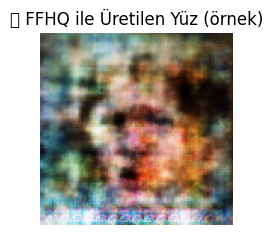


🔁 Epoch 2/100 başladı...


Epoch 2/100: 100%|██████████| 4375/4375 [03:21<00:00, 21.66it/s]


✅ Epoch 2 bitti | G Loss: 635.1085 | D Loss: 1438.9430


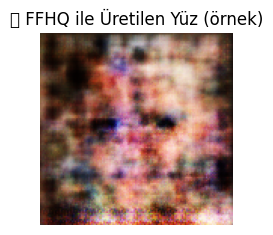


🔁 Epoch 3/100 başladı...


Epoch 3/100: 100%|██████████| 4375/4375 [03:20<00:00, 21.77it/s]


✅ Epoch 3 bitti | G Loss: 1114.4528 | D Loss: 1623.3941


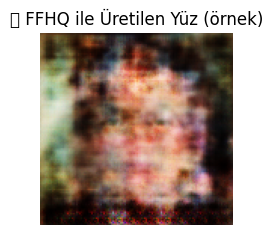


🔁 Epoch 4/100 başladı...


Epoch 4/100: 100%|██████████| 4375/4375 [03:22<00:00, 21.62it/s]


✅ Epoch 4 bitti | G Loss: 787.3500 | D Loss: 1313.7917


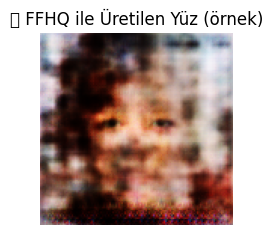


🔁 Epoch 5/100 başladı...


Epoch 5/100: 100%|██████████| 4375/4375 [03:22<00:00, 21.56it/s]


✅ Epoch 5 bitti | G Loss: 660.1284 | D Loss: 1032.1814


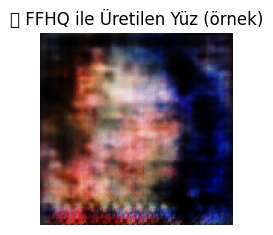


🔁 Epoch 6/100 başladı...


Epoch 6/100: 100%|██████████| 4375/4375 [03:22<00:00, 21.57it/s]


✅ Epoch 6 bitti | G Loss: 875.0222 | D Loss: 895.5857


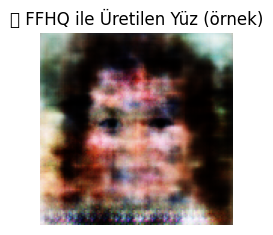


🔁 Epoch 7/100 başladı...


Epoch 7/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.52it/s]


✅ Epoch 7 bitti | G Loss: 817.9452 | D Loss: 777.0914


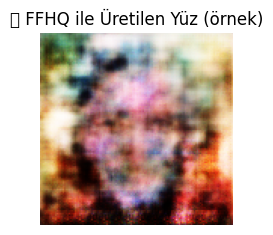


🔁 Epoch 8/100 başladı...


Epoch 8/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.51it/s]


✅ Epoch 8 bitti | G Loss: 816.7500 | D Loss: 704.0850


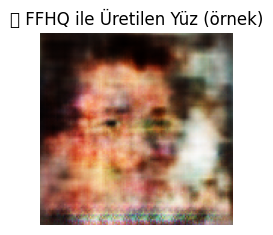


🔁 Epoch 9/100 başladı...


Epoch 9/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.51it/s]


✅ Epoch 9 bitti | G Loss: 1126.4317 | D Loss: 294.9517


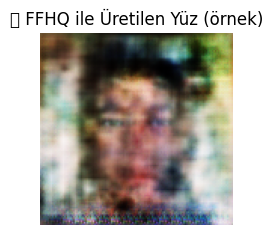


🔁 Epoch 10/100 başladı...


Epoch 10/100: 100%|██████████| 4375/4375 [03:25<00:00, 21.27it/s]


✅ Epoch 10 bitti | G Loss: 1233.1363 | D Loss: -257.6219


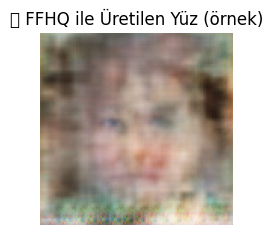


🔁 Epoch 11/100 başladı...


Epoch 11/100: 100%|██████████| 4375/4375 [03:24<00:00, 21.39it/s]


✅ Epoch 11 bitti | G Loss: 1168.8270 | D Loss: -618.7287


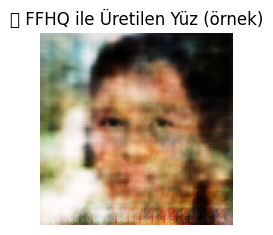


🔁 Epoch 12/100 başladı...


Epoch 12/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.53it/s]


✅ Epoch 12 bitti | G Loss: 1289.5085 | D Loss: -859.2667


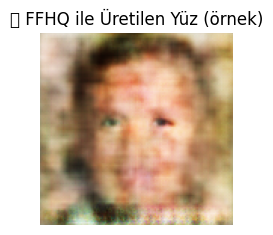


🔁 Epoch 13/100 başladı...


Epoch 13/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.47it/s]


✅ Epoch 13 bitti | G Loss: 1490.1722 | D Loss: -1045.2046


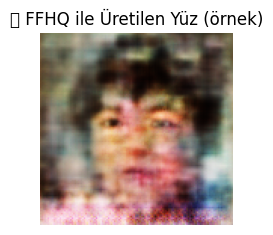


🔁 Epoch 14/100 başladı...


Epoch 14/100: 100%|██████████| 4375/4375 [03:22<00:00, 21.57it/s]


✅ Epoch 14 bitti | G Loss: 1247.7948 | D Loss: -1233.7277


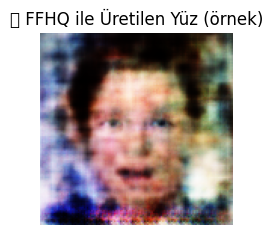


🔁 Epoch 15/100 başladı...


Epoch 15/100: 100%|██████████| 4375/4375 [03:22<00:00, 21.62it/s]


✅ Epoch 15 bitti | G Loss: 1548.5126 | D Loss: -1295.4947


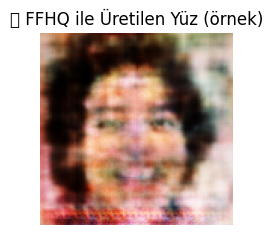


🔁 Epoch 16/100 başladı...


Epoch 16/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.51it/s]


✅ Epoch 16 bitti | G Loss: 1223.5418 | D Loss: -1384.3786


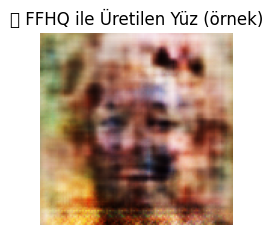


🔁 Epoch 17/100 başladı...


Epoch 17/100: 100%|██████████| 4375/4375 [03:22<00:00, 21.63it/s]


✅ Epoch 17 bitti | G Loss: 1791.2665 | D Loss: -1368.1076


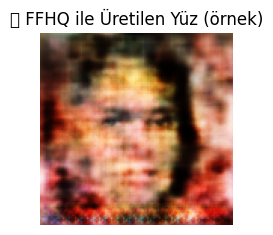


🔁 Epoch 18/100 başladı...


Epoch 18/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.52it/s]


✅ Epoch 18 bitti | G Loss: 1544.4748 | D Loss: -1412.3470


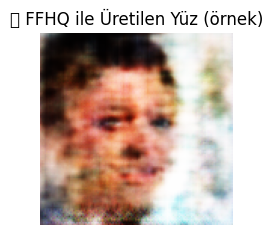


🔁 Epoch 19/100 başladı...


Epoch 19/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.45it/s]


✅ Epoch 19 bitti | G Loss: 1534.4794 | D Loss: -1439.3238


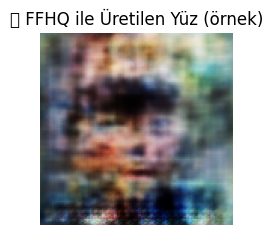


🔁 Epoch 20/100 başladı...


Epoch 20/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.54it/s]


✅ Epoch 20 bitti | G Loss: 1334.7963 | D Loss: -1441.6633


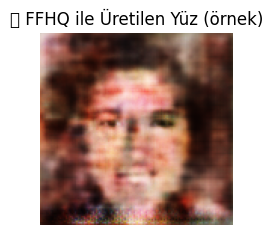


🔁 Epoch 21/100 başladı...


Epoch 21/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.51it/s]


✅ Epoch 21 bitti | G Loss: 1476.7476 | D Loss: -1425.2956


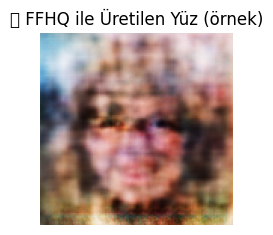


🔁 Epoch 22/100 başladı...


Epoch 22/100: 100%|██████████| 4375/4375 [03:24<00:00, 21.44it/s]


✅ Epoch 22 bitti | G Loss: 1347.0450 | D Loss: -1460.9799


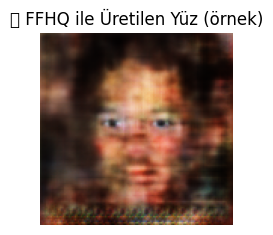


🔁 Epoch 23/100 başladı...


Epoch 23/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.47it/s]


✅ Epoch 23 bitti | G Loss: 1146.4687 | D Loss: -1450.2535


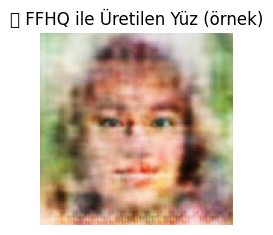


🔁 Epoch 24/100 başladı...


Epoch 24/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.45it/s]


✅ Epoch 24 bitti | G Loss: 1442.3878 | D Loss: -1503.3211


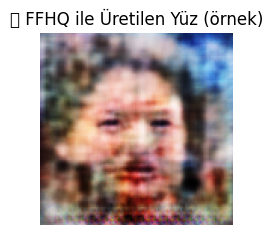


🔁 Epoch 25/100 başladı...


Epoch 25/100: 100%|██████████| 4375/4375 [03:24<00:00, 21.42it/s]


✅ Epoch 25 bitti | G Loss: 1510.5801 | D Loss: -1523.9362


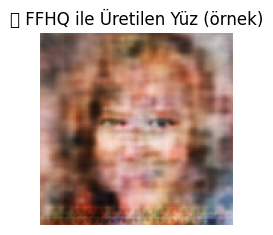


🔁 Epoch 26/100 başladı...


Epoch 26/100: 100%|██████████| 4375/4375 [03:24<00:00, 21.43it/s]


✅ Epoch 26 bitti | G Loss: 1443.1903 | D Loss: -1544.1815


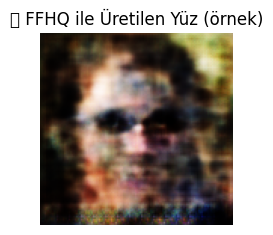


🔁 Epoch 27/100 başladı...


Epoch 27/100: 100%|██████████| 4375/4375 [03:24<00:00, 21.44it/s]


✅ Epoch 27 bitti | G Loss: 1530.0303 | D Loss: -1598.7602


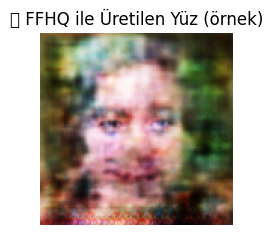


🔁 Epoch 28/100 başladı...


Epoch 28/100: 100%|██████████| 4375/4375 [03:24<00:00, 21.37it/s]


✅ Epoch 28 bitti | G Loss: 1304.6854 | D Loss: -1545.3711


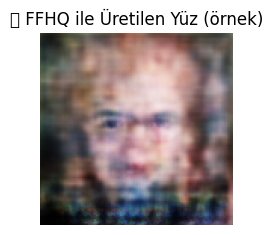


🔁 Epoch 29/100 başladı...


Epoch 29/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.45it/s]


✅ Epoch 29 bitti | G Loss: 1585.4908 | D Loss: -1581.0427


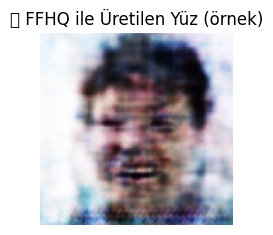


🔁 Epoch 30/100 başladı...


Epoch 30/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.54it/s]


✅ Epoch 30 bitti | G Loss: 1739.8426 | D Loss: -1610.1228


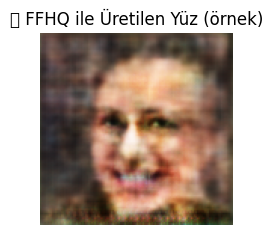


🔁 Epoch 31/100 başladı...


Epoch 31/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.46it/s]


✅ Epoch 31 bitti | G Loss: 1356.5344 | D Loss: -1581.4755


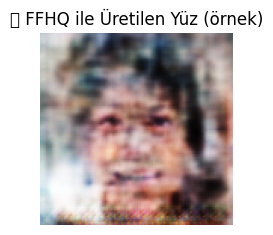

💾 En iyi model working dizinine kaydedildi! (Epoch 31)

🔁 Epoch 32/100 başladı...


Epoch 32/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.50it/s]


✅ Epoch 32 bitti | G Loss: 1558.6180 | D Loss: -1593.5761


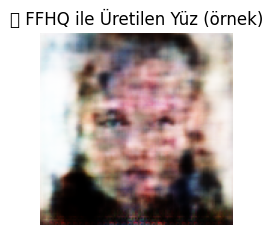

⚠️ Gelişme yok (1/5)

🔁 Epoch 33/100 başladı...


Epoch 33/100: 100%|██████████| 4375/4375 [03:23<00:00, 21.45it/s]


✅ Epoch 33 bitti | G Loss: 1568.2882 | D Loss: -1543.5467


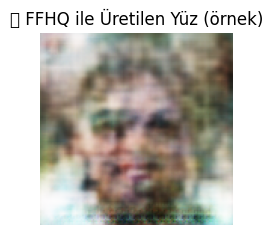

⚠️ Gelişme yok (2/5)

🔁 Epoch 34/100 başladı...


Epoch 34/100: 100%|██████████| 4375/4375 [03:25<00:00, 21.31it/s]


✅ Epoch 34 bitti | G Loss: 1731.8701 | D Loss: -1604.0685


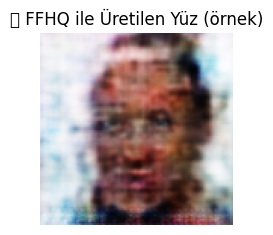

⚠️ Gelişme yok (3/5)

🔁 Epoch 35/100 başladı...


Epoch 35/100: 100%|██████████| 4375/4375 [03:24<00:00, 21.43it/s]


✅ Epoch 35 bitti | G Loss: 1428.4419 | D Loss: -1548.8638


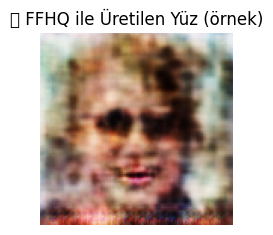

⚠️ Gelişme yok (4/5)

🔁 Epoch 36/100 başladı...


Epoch 36/100: 100%|██████████| 4375/4375 [03:24<00:00, 21.44it/s]


✅ Epoch 36 bitti | G Loss: 1616.9244 | D Loss: -1492.2902


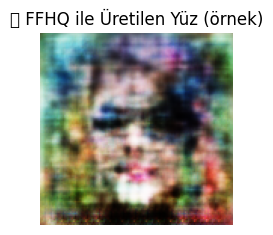

⚠️ Gelişme yok (5/5)
🛑 Early stopping tetiklendi! (Epoch 36)
💾 En iyi model working dizinine kaydedildi! (Epoch 36)
✅ Eğitim tamamlandı.


In [80]:
train_ffhq()

In [134]:
import shutil
src = "/kaggle/working/generator_ffhq_pretrained.pth"
dst = "/kaggle/working/generator_ffhq_READY.pth"

if os.path.exists(src):
    shutil.copy(src, dst)
    print("✅ Model kurtarıldı: READY versiyonu oluşturuldu.")
else:
    print("❌ Henüz model kaydedilmemiş gibi görünüyor.")


✅ Model kurtarıldı: READY versiyonu oluşturuldu.


In [46]:
# 💾 Eğitim bittiğinde modeli indirilebilir klasöre kopyala
import shutil
final_path = "/kaggle/working/generator_ffhq_pretrained.pth"
download_path = "/kaggle/working/generator_ffhq_ready_for_download.pth"

if os.path.exists(final_path):
    shutil.copy(final_path, download_path)
    print(f"⬇️ Model indirilmeye hazır: {download_path}")
else:
    print("❌ Model dosyası bulunamadı, kopyalama yapılamadı.")


⬇️ Model indirilmeye hazır: /kaggle/working/generator_ffhq_ready_for_download.pth


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


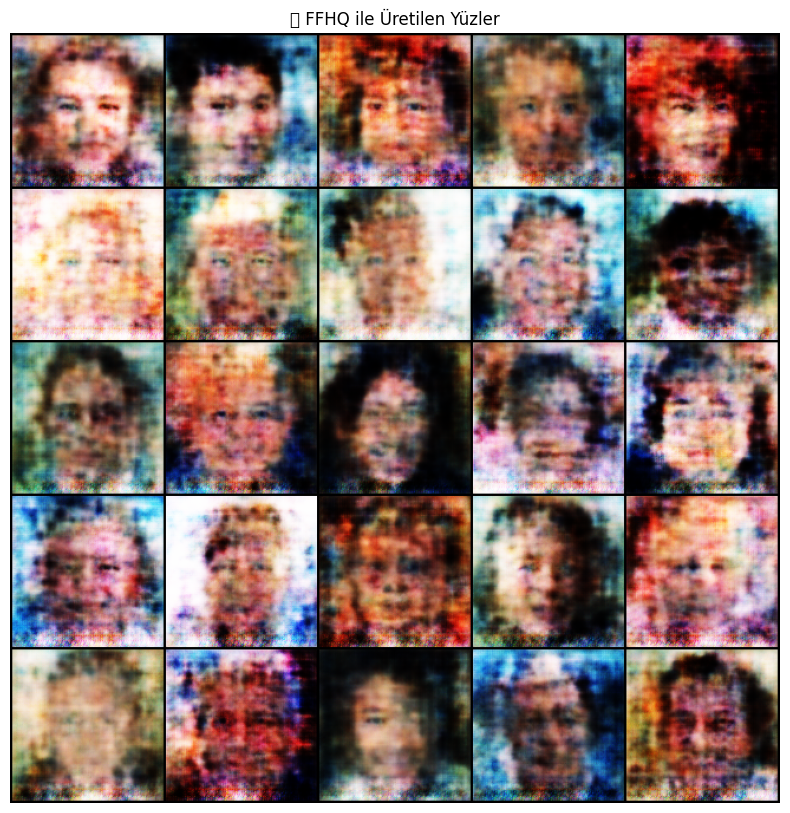

In [81]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch
from collections import OrderedDict

def test_generator_model():
    # Modeli tanımla
    generator = Generator().to(DEVICE)

    # Ağırlıkları yükle
    model_path = "/kaggle/input/generator_ffhq_pretrained/pytorch/default/1/generator_ffhq_pretrained(1).pth"
    state_dict = torch.load(model_path, map_location=DEVICE)

    # Eğer 'module.' öneki varsa kaldır
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v

    generator.load_state_dict(new_state_dict)
    generator.eval()

    # Rastgele latent vektör üret
    z = torch.randn(25, LATENT_DIM).to(DEVICE)

    # Görsel üret
    with torch.no_grad():
        fake_images = generator(z)

    # Görselleri grid'e yerleştir ve göster
    grid = make_grid(fake_images, nrow=5, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("🧠 FFHQ ile Üretilen Yüzler")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

# Fonksiyonu çağır
test_generator_model()


In [82]:
#WAV NPY DÖNÜŞÜMÜ İMDAT

import os
import torchaudio
import numpy as np
import torch

# === Yollar ===
AUDIO_INPUT_DIR = "/kaggle/input/gen-ai/gen_AI/audio"
AUDIO_OUTPUT_DIR = "/kaggle/working/audio_vectors"
os.makedirs(AUDIO_OUTPUT_DIR, exist_ok=True)

# === Ayarlar ===
TARGET_SAMPLE_RATE = 16000
MAX_LENGTH = 16000  # 1 saniye = 16.000 örnek

# === Dönüştürme İşlemi ===
for fname in os.listdir(AUDIO_INPUT_DIR):
    if fname.endswith(".wav"):
        full_path = os.path.join(AUDIO_INPUT_DIR, fname)
        try:
            waveform, sample_rate = torchaudio.load(full_path)
            waveform = waveform.mean(dim=0)  # stereo ise mono'ya indir

            if sample_rate != TARGET_SAMPLE_RATE:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=TARGET_SAMPLE_RATE)
                waveform = resampler(waveform)

            waveform = waveform[:MAX_LENGTH]
            if waveform.shape[0] < MAX_LENGTH:
                waveform = torch.nn.functional.pad(waveform, (0, MAX_LENGTH - waveform.shape[0]))

            out_path = os.path.join(AUDIO_OUTPUT_DIR, fname.replace(".wav", ".npy"))
            np.save(out_path, waveform.numpy())

        except Exception as e:
            print(f"❌ Hata oluştu: {fname} - {e}")

print("✅ WAV → NPY dönüşümü tamamlandı!")


✅ WAV → NPY dönüşümü tamamlandı!


In [83]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchvision.transforms import ToPILImage
import librosa

# === Ayarlar ===
IMG_SIZE = 128
LATENT_DIM = 128
BATCH_SIZE = 16
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CSV_PATH = "/kaggle/input/yenidatabase0/yeni_database_with_gender.csv"
AUDIO_DIR = "/kaggle/working/audio_vectors"
IMAGE_DIR = "/kaggle/input/gen-ai/gen_AI/faces_64x64"


In [84]:
class AudioToFaceDataset(Dataset):
    def __init__(self, csv_path, audio_dir, image_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.image_dir = image_dir
        self.df["photo"] = self.df["photo"].str.strip()
        self.df["audio_name"] = self.df["audio_name"].str.strip()

        self.transform = transform or transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            audio_path = os.path.join(self.audio_dir, row["audio_name"])
            image_path = os.path.join(self.image_dir, row["photo"])

            audio_vector = torch.tensor(np.load(audio_path), dtype=torch.float32)  # (16000,)
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)
            return audio_vector, image
        except:
            return None

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None
    return torch.stack([b[0] for b in batch]), torch.stack([b[1] for b in batch])


In [99]:
class AudioToLatent(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(16384, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, LATENT_DIM)
        )

    def forward(self, x):
        return self.encoder(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(LATENT_DIM, 512*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),     # 64x64
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 64x64 → 32x32
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256*16*16, 1)
        )

    def forward(self, x):
        return self.net(x)


In [100]:
def train_finetune():
    dataset = AudioToFaceDataset(CSV_PATH, AUDIO_DIR, IMAGE_DIR)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

    audio_encoder = AudioToLatent().to(DEVICE)
    generator = Generator().to(DEVICE)
    discriminator = Discriminator().to(DEVICE)

    # Pretrained generator yükleniyor (eğer varsa)
    pretrained_path = "/kaggle/input/generator_ffhq_pretrained.pth"
    if os.path.exists(pretrained_path):
        state_dict = torch.load(pretrained_path, map_location=DEVICE)
        new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
        generator.load_state_dict(new_state_dict)
        print("✅ Pretrained generator yüklendi.")

    g_optimizer = optim.Adam(list(audio_encoder.parameters()) + list(generator.parameters()), lr=5e-5)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
    criterion = nn.BCEWithLogitsLoss()

    best_g_loss = float("inf")
    patience = 10
    counter = 0

    for epoch in range(EPOCHS):
        g_loss_epoch = 0
        d_loss_epoch = 0

        for audio_batch, real_images in dataloader:
            if audio_batch is None:
                continue

            audio_batch = audio_batch.to(DEVICE)
            real_images = real_images.to(DEVICE)
            batch_size = audio_batch.size(0)
            real_labels = torch.ones(batch_size, 1).to(DEVICE)
            fake_labels = torch.zeros(batch_size, 1).to(DEVICE)

            # === Discriminator
            with torch.no_grad():
                z = audio_encoder(audio_batch)
                fake_images = generator(z)

            d_real = discriminator(real_images)
            d_fake = discriminator(fake_images)
            d_loss = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            d_loss_epoch += d_loss.item()

            # === Generator
            z = audio_encoder(audio_batch)
            fake_images = generator(z)
            pred = discriminator(fake_images)
            g_loss = criterion(pred, real_labels)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            g_loss_epoch += g_loss.item()

        print(f"📊 Epoch {epoch+1}/{EPOCHS} | G Loss: {g_loss_epoch:.4f} | D Loss: {d_loss_epoch:.4f}")

        if g_loss_epoch < best_g_loss - 1e-4:
            best_g_loss = g_loss_epoch
            counter = 0
            torch.save(generator.state_dict(), "/kaggle/working/fine_tuned_generator.pth")
            print("💾 Yeni en iyi model kaydedildi!")
        else:
            counter += 1
            print(f"⏳ Gelişme yok ({counter}/{patience})")
            if counter >= patience:
                print("🛑 Early stopping tetiklendi.")
                break


In [101]:

def convert_audio_to_npy(audio_path, sr=16000):
    try:
        wav, _ = librosa.load(audio_path, sr=sr)
        wav = librosa.util.fix_length(wav, size=sr)
        return torch.tensor(wav, dtype=torch.float32).unsqueeze(0)
    except Exception as e:
        print(f"❌ Ses dönüştürme hatası: {e}")
        return None

def test_custom_audio(audio_path):
    audio_vec = convert_audio_to_npy(audio_path)
    if audio_vec is None:
        print("Ses alınamadı.")
        return

    # 📥 Model yükle
    audio_encoder = AudioToLatent().to(DEVICE)
    generator = Generator().to(DEVICE)
    state_dict = torch.load("/kaggle/working/fine_tuned_generator.pth", map_location=DEVICE)
    generator.load_state_dict(state_dict)
    generator.eval()
    audio_encoder.eval()

    audio_vec = audio_vec.to(DEVICE)

    with torch.no_grad():
        z = audio_encoder(audio_vec)
        generated_image = generator(z)
        generated_image = (generated_image + 1) / 2.0  # normalize [0,1]

    img = generated_image.squeeze(0).cpu()
    plt.figure(figsize=(4, 4))
    plt.imshow(ToPILImage()(img))
    plt.axis("off")
    plt.title("🎭 Üretilen Yüz")
    plt.show()


In [102]:
# Eğitimi çalıştır
train_finetune()

# Test et (örnek ses dosyası)
# test_custom_audio("/kaggle/input/ses-dosyasi/ornek_ses.mp3")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x16000 and 16384x4096)